# **BUSI 488 / COMP 488 Data Science in the Business World**
## *Spring 2023*  
Daniel M. Ringel and Jack Snoeyink

Kenan-Flagler Business School and UNC Department of Computer Science 

*The University of North Carolina at Chapel Hill*  
dmr@unc.edu and snoeyink@cs.unc.edu

## Class 09 - **Business Applications:** Market Basket Analysis
*Febrary 7, 2023*  
Version 1.2



## Today's Agenda

1. **Market Basket Analysis** 
2. **Association Rule Mining** 
3. **Team Assignment 2:** Helping a local Coffee Shop with Data Science

## Prep-Check:

- Reported XP for DataCamp Homework 4 on Canvas
- Read: Gabel, S., Guhl, D. and Klapper, D., 2019. P2V-MAP: mapping market structures for large retail assortments. Journal of Marketing Research, 56(4), pp.557-580.

# 1 Market Basket Analysis

- **Collection of methods** that examine basket composition: products that customers co-purchase on a single shopping trip 
- The **origins of market basket analysis** lie in the association rules framework by Agrawal, Imieliński, and Swami (1993). 
- The **purpose** of market basket anbalysis is to measure the extent to which any two products of an assortment are associated with another. 
- **Retailers** can use the framework’s association metrics to inform co-promotion, cross-selling and product bundling. 






*Agrawal, Rakesh, Tomasz Imieliński, and Arun Swami (1993), "Mining Association Rules between Sets of Items in Large Databases," in Proceedings of the 1993 ACM SIGMOD International Conference on Management of Data.*

### **Dr. D's Amazin' Coffee Shop**   

Cleary, every grocery store needs a little coffee shop inside these days.  
At least, that's what Dr. D. thinks - so he opened one inside his Amazin' grocery store.      
  
    
A few months after his new coffee shop opened, Dr. D. started to wonder whether his **assortment of SKUs (stock keeping units) is optimal**:
- Are there any opportunities to bundle SKUs to sell more? Which?
- What types of additional SKUs, if any, should he add to his assortment?
- Are existing SKUs already cannibalizing each other?
- Are there any meaningful categories that his assortment can be divided into?  

Dr. D. once learned in a marketing class that it is **important to consider consumers' perspectives** in business decisions. By looking through their eyes, you can learn more about their needs and identify behavioral patterns that might help you serve them better-and increase your revenue!   

He therefore sampled over 70 **transactions from his coffee shop's cashier's log** to study substitutability and complementarity of SKUs in his assortment.     

***How might supervised learning help Dr. D. find some answers to his questions?***

## 1.1 Load Coffee Shop Transactions

In [ ]:
# 0. Connect your Google Drive
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/488/Class09
!ls # special shell command to view the files in the home directory of the notebook environment

Mounted at /content/drive
/content/drive/MyDrive/488/Class09
488_2023_Class09.ipynb	DrDsAmazinCoffeeShop.csv


In [ ]:
# 1. Import packages
import pandas as pd
import numpy as np

# 2. Read transaction data into a DataFrame
df = pd.read_csv('DrDsAmazinCoffeeShop.csv')
df

,Transaction,Item,Price
0,ne75ndsgs,latte,3.39
1,ne75ndsgs,coffee,2.29
2,ne75ndsgs,donut,1.99
3,ne75ndsgs,donut,1.99
4,089gdgd7,latte,3.39
...,...,...,...
138,uzr54367,skinny latte,3.39
139,uzr54367,protein bar,2.49
140,zj6425643h,coffee,2.29
141,zn72gsss,coffee,2.29


## 1.2 Summary Statistics of SKUs

Several basic questions present themselves when we analyze transactional data from a coffeeshop (or any other retailer):

- What SKUs were sold?
- How many of each SKU were sold?
- At what price were SKUs sold?
- What is the revenue contribution of each SKU?
- In how many shopping baskets was each SKU?

In [ ]:
# 1. Get a first impression by aggregating some data into summary statistics at the item (SKU) level using .groupby() and .agg()
SKUs = df.groupby('Item').agg( UnitsSold=('Item', 'count'), MeanPrice=('Price', 'mean'), Revenue=('Price', 'sum'), InBaskets=('Transaction', 'nunique')).copy()
SKUs.reset_index(inplace=True)
SKUs

,Item,UnitsSold,MeanPrice,Revenue,InBaskets
0,coffee,24,2.29,54.96,24
1,coke,11,1.89,20.79,11
2,diet coke,7,1.89,13.23,7
3,donut,18,1.99,35.82,16
4,ice tea,12,1.69,20.28,12
5,latte,20,3.39,67.80,20
6,protein bar,10,2.49,24.90,10
7,salad,11,4.99,54.89,11
8,sandwich,19,5.99,113.81,17
9,skinny latte,11,3.39,37.29,11


## 1.3 Co-Occurrence of SKUs in Shopping Baskets

We can also analyze which SKUs are frequently purchased together?

***What might such information be useful for?***



In [ ]:
# We can aggregate the information of which SKUs were purchased jointly in a co-occurrence matrix.

# 1. Here is a function that generates a co-occurrence matrix from a cashier's log (Dr. D's particular coffee shop log!)
#    Note that the diagonal of the returned matrix is the number of baskets each SKU was included in

'''This Function translates a cashier log into a square, symmetric co-occurrence matrix
The input is a cashlog with a column of transaction IDs and a column on SKU names (or IDs)
The output is a square, symmetric co-occurrence matrix'''
def createCoMatrixEfficient(cashlog):
    df = pd.get_dummies(cashlog.Transaction).groupby(cashlog.Item).apply(max)
    df= df.sort_index()
    unique_items = df.index.unique().tolist()
    id_to_item = dict(zip(range(len(unique_items)), unique_items))
    matrix = df.values
    co = np.matmul(matrix.astype(int),matrix.T.astype(int))
    return co, id_to_item

In [ ]:
#@title Default title text
# 2. We pass our dataframe with the cashier's log to the function to generate the co-occurrence matrix and a list of column/row labels
co, id_to_item  = createCoMatrixEfficient(df)
display(id_to_item)
co

{0: 'coffee',
 1: 'coke',
 2: 'diet coke',
 3: 'donut',
 4: 'ice tea',
 5: 'latte',
 6: 'protein bar',
 7: 'salad',
 8: 'sandwich',
 9: 'skinny latte'}

array([[24,  1,  0,  8,  0,  6,  3,  0,  0,  2],
       [ 1, 11,  1,  0,  5,  0,  0,  3,  7,  0],
       [ 0,  1,  7,  0,  1,  0,  2,  5,  4,  1],
       [ 8,  0,  0, 16,  0,  7,  2,  0,  0,  2],
       [ 0,  5,  1,  0, 12,  0,  0,  5,  8,  0],
       [ 6,  0,  0,  7,  0, 20,  2,  0,  0,  2],
       [ 3,  0,  2,  2,  0,  2, 10,  1,  0,  5],
       [ 0,  3,  5,  0,  5,  0,  1, 11,  4,  1],
       [ 0,  7,  4,  0,  8,  0,  0,  4, 17,  0],
       [ 2,  0,  1,  2,  0,  2,  5,  1,  0, 11]])

In [ ]:
# 3. Make sure that we know which row/column refers to each product in the assortment!

# Create a Dataframe with the Matrix IDs and the SKU Names
SKU_Matrix = pd.DataFrame(id_to_item.items(), columns=['MatrixID', 'Item'])
SKU_Matrix

,MatrixID,Item
0,0,coffee
1,1,coke
2,2,diet coke
3,3,donut
4,4,ice tea
5,5,latte
6,6,protein bar
7,7,salad
8,8,sandwich
9,9,skinny latte


In [ ]:
# 4. Because we already have a SKU dataframe with some summary statistics, we need to merge the two item dataframes:
SKUs= pd.merge(SKU_Matrix, SKUs, on='Item', how='outer')
SKUs

,MatrixID,Item,UnitsSold,MeanPrice,Revenue,InBaskets
0,0,coffee,24,2.29,54.96,24
1,1,coke,11,1.89,20.79,11
2,2,diet coke,7,1.89,13.23,7
3,3,donut,18,1.99,35.82,16
4,4,ice tea,12,1.69,20.28,12
5,5,latte,20,3.39,67.80,20
6,6,protein bar,10,2.49,24.90,10
7,7,salad,11,4.99,54.89,11
8,8,sandwich,19,5.99,113.81,17
9,9,skinny latte,11,3.39,37.29,11


## 1.4 Normalization of Co-Occurrence

We could ***directly analyze co-purchases*** of SKUs
  - Some SKUs are purchased a lot together
  - Other SKUs are rarely purchased together  

What if we want to know ***how strongly related SKUs*** are?

----
  - SKU A was in 10 baskets
  - SKU B was in 10 baskets
  - SKUs A and B were jointly in 5 baskets (co-purchased)  
  

  - SKU C was in 4 baskets
  - SKU D was in 4 baskets
  - SKUs C and D were jointly in 4 baskets (co-purchased) 

----

***Which SKUs are more strongly related?***

1. A and B
2. C and D

In [ ]:
# We will use mean conditional probability for normalization (as probabilistic alternative to a Jaccard index or cosine/lift)

# 1. divide row elements by their maximum (which corresponds to the number of baskets each SKU was in)
co=co*1./np.max(co, axis=1)

# 2. Average upper and lower triangles
display(np.round((co.T+co)/2,1))
co=np.round((co.T+co)/2,5)

# Why mean conditional probability?

array([[1. , 0.1, 0. , 0.4, 0. , 0.3, 0.2, 0. , 0. , 0.1],
       [0.1, 1. , 0.1, 0. , 0.4, 0. , 0. , 0.3, 0.5, 0. ],
       [0. , 0.1, 1. , 0. , 0.1, 0. , 0.2, 0.6, 0.4, 0.1],
       [0.4, 0. , 0. , 1. , 0. , 0.4, 0.2, 0. , 0. , 0.2],
       [0. , 0.4, 0.1, 0. , 1. , 0. , 0. , 0.4, 0.6, 0. ],
       [0.3, 0. , 0. , 0.4, 0. , 1. , 0.2, 0. , 0. , 0.1],
       [0.2, 0. , 0.2, 0.2, 0. , 0.2, 1. , 0.1, 0. , 0.5],
       [0. , 0.3, 0.6, 0. , 0.4, 0. , 0.1, 1. , 0.3, 0.1],
       [0. , 0.5, 0.4, 0. , 0.6, 0. , 0. , 0.3, 1. , 0. ],
       [0.1, 0. , 0.1, 0.2, 0. , 0.1, 0.5, 0.1, 0. , 1. ]])

Can you ***easily tell*** from the above matrix which items are ***likely complementary items*** from consumers' perspectives?

- Not necessarily easy even in a simple setting
- Very difficult (perhaps impossible) with dozens or even hundreds of items!



## 1.5 Community Detection on Normalized Co-Occurrence Data
Let's see if there are groups of frequently co-purchased items using Community Detection.


In [ ]:
# If you want to run this on your own computer, you must first install the required package.
# Make sure you install from your terminal (Mac) or Anaconda prompt (Windows)
# pip install python-louvain
# pip install networkx

# 1. First, we create a graph object from our matrix (co) using a package called networkx
import networkx as nx
G = nx.from_numpy_array(co)

# 2. Import and detect communities
from community import community_louvain
labels = community_louvain.best_partition(G, partition=None, weight='weight', resolution=1, randomize=None, random_state=None)

# 3. Get the cluster (community) assignments from the community detection output
C = np.fromiter(labels.values(), dtype=float)+1

# 4. Check the quality of the identified communities (i.e., community assignments) using modularity
print('Modularity:',community_louvain.modularity(labels, G))

# 5. Add cluster assignments (community labels) to our SKU DataFrame
SKUs['clusters'] = C.astype('int')

# 6. Inspect Community Assignments
print('Labels:',C)

Modularity: 0.5503870718764768
Labels: [4. 2. 3. 4. 2. 4. 1. 3. 2. 1.]


Modularity is NOT a percent so 0.55% 0.5 Modularity is crazy good.

## 1.6 Assortment Map
It's often a lot easier to understand higher dimensional data when they are visualized in lower dimensions.   
t-SNE can help us do so for Dr. D.'s coffee shop assortment.

**Problem?** 
- t-SNE operates on feature vectors. 
- We have a normalized co-occurrence matrix.

**Solution!** 
- We can think of our normalized co-occurrence matrix as a *Similarity* matrix 
- Spatially, *Similarity* can be thought of as *Proximity*
- *Proximity* can be ***inverted*** to obtain *Distance*
- Internally, t-SNE finds distances between the input feature vectors
- We can ***tell t-SNE that we already have distances***: Our inverted similarity matrix!
- Must specify additional ***hyperparameter***: *metric = 'precomputed'*


In [ ]:
# 1. t-SNE requires a Distance Matrix. Must convert Similarity matrix to Distance matrix
D = 1 - co  
# Alternative: D = 1 / np.maximum(co, 1e-8)  # But what does this alternative really do? When might that be useful?

# 2. Import packages
from sklearn.manifold import TSNE

# 3. Instantiate and Fit t-SNE to Data
Y = TSNE(n_components = 2, verbose=1, perplexity = 5, n_iter=1000, learning_rate=200, metric = 'precomputed', init='random', square_distances=True, random_state=1).fit_transform(D)

[t-SNE] Computing 9 nearest neighbors...
[t-SNE] Indexed 10 samples in 0.001s...
[t-SNE] Computed neighbors for 10 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 10 / 10
[t-SNE] Mean sigma: 0.498206
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.929947
[t-SNE] KL divergence after 1000 iterations: 0.045582


In [ ]:
Y

array([[ 135.37173 , -125.39731 ],
       [-325.02127 ,   76.91154 ],
       [-125.54549 ,    7.032925],
       [ 226.3306  , -132.1699  ],
       [-283.46146 ,  180.34314 ],
       [ 240.88672 ,  -39.495235],
       [  54.02822 ,   18.534243],
       [-209.68056 ,  -27.429987],
       [-222.27531 ,  108.441536],
       [ 100.9709  ,   87.00355 ]], dtype=float32)

This outputs features in two dimensions and I can simply evaluate them as X & Y cordinates to plot them!

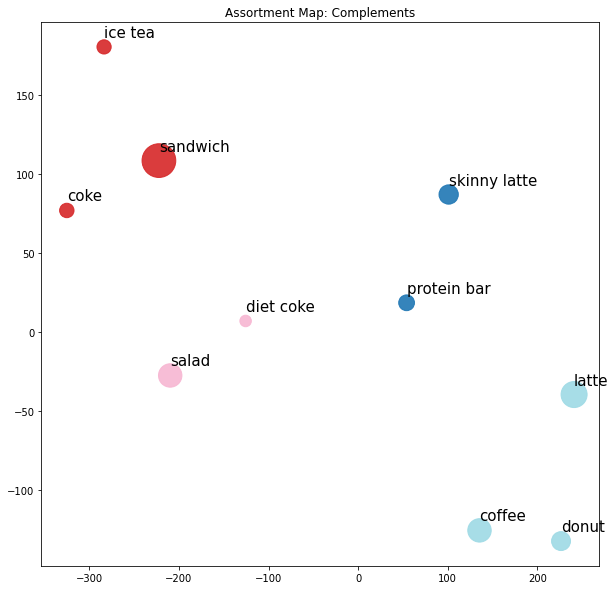

In [ ]:
# 4. Import packages
import matplotlib.pyplot as plt

# 5. Visualize the Output of t-SNE
plt.figure(figsize=(10, 10))
plt.scatter(Y[:, 0], Y[:, 1], c=SKUs.clusters.values, cmap='tab20', s=SKUs.Revenue.values*10, alpha=0.9)
plt.title('Assortment Map: Complements')
for i, label in enumerate(SKUs.Item.to_list()):
    plt.annotate(label, (Y[i, 0], Y[i, 1]),textcoords="offset points", xytext=(0,10),size=15)

In reality, remove axes fraom graph as they are arbitrary and just list as latent feature 1 and latent feature 2

## 1.7 Interactive Maps with Altair

Altair is a powerful tool to visualize complex data. I'll use altair for plotting an interactive map.  (Here is an in-depth tutorial, if you are interested: https://github.com/uwdata/visualization-curriculum#readme)

---



In [ ]:
# 0. Instantiate and Fit t-SNE to Data
from sklearn.manifold import TSNE
Y = TSNE(n_components = 2, verbose=1, perplexity = 5, n_iter=1000, learning_rate=200, metric = 'precomputed', init='random', square_distances=True, random_state=1).fit_transform(D)

# 1. Create a new DataFrame that holds all the information we need for our map
import pandas as pd
source = pd.DataFrame(
    {'x': Y[:,0],
     'y': Y[:,1],
     'txt': SKUs["Item"],
     'Cluster' : SKUs['clusters'],
     'Revenue' : SKUs['Revenue']
    })

# 2. Import Altair
import altair as alt

# 3. Define Bubbles on Map
bubbles = alt.Chart(source).mark_circle().encode(
    #x='x:Q',
    #y='y:Q',
    x=alt.X('x:Q', axis=alt.Axis(title="not directly interpretable", grid=False, labels=False),scale=alt.Scale(domain=[min(source.x)-10, max(source.x)+20])),
    y=alt.Y('y:Q', axis=alt.Axis(title="not directly interpretable", grid=False, labels=False),scale=alt.Scale(domain=[min(source.y)-10, max(source.y)+10])),
    size='Revenue:Q',
    color = 'Cluster:N'
    )

# 4. Define Bubble Labels on Map
text = alt.Chart(source).mark_text(
    align='left',
    baseline='middle',
    dx=10
    ).encode(
    x='x:Q',
    y='y:Q',
    text='txt',
    #color = 'Cluster:N'
)

# 5. Visualizes Bubbles and Labels in an interactive Mao
bubbles + text.encode(text='txt').interactive().properties(height=400,width=400,title="Co-Purchases at Dr. D.'s Amazin' Coffee Shop - Use Mouse to move (drag) and Zoom (wheel)")  

[t-SNE] Computing 9 nearest neighbors...
[t-SNE] Indexed 10 samples in 0.000s...
[t-SNE] Computed neighbors for 10 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 10 / 10
[t-SNE] Mean sigma: 0.498206
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.929947
[t-SNE] KL divergence after 1000 iterations: 0.045582


alt.LayerChart(...)

# 2. Association Rule Mining
*Digging deeper into how the purchase of certain items influences others.* 

Data scientists are able to carry out Market Basket Analysis by implementing Association Rule Mining. **Association Rule Mining** is a rule-based machine learning method that helps to uncover meaningful correlations between different products according to their co-occurrence in a data set.


The **apriori algorithm** is an efficient way to help us identify frequent itemsets while filtering out the infrequent ones. It can remove itemsets from consideration without having to evaluate them. 

***Check out these tutorials!***


- [Understanding Consumer Behavior With The Market Basket Analysis](https://towardsdatascience.com/understanding-consumer-behavior-with-the-market-basket-analysis-3d0c017e5613)

- [Data Mining: Market Basket Analysis with Apriori Algorithm](https://towardsdatascience.com/data-mining-market-basket-analysis-with-apriori-algorithm-970ff256a92c)


###Association Rules Metrics Explained

**Support:** How popular a combination or bundle is. How many times it occurred across of all transactions.

**Confidence:** How likely the consequent is purchased given the antecedent is purchased. antecedent: a given b

**Lift:** How likely the consequent is purchased given the antecedent is purchased controlling for popularity of the consequent. (Lift of 1 means no association, greater than one means that the consequent is more likely given the antecedent, less than 1 means that choosing one decreases the chance of choosing the other).

https://www.thedataschool.co.uk/liu-zhang/understanding-lift-for-market-basket-analysis

## 2.1 Get Transactions into Correct Format
We need to prepare our transaction data for apriori analysis in 2 steps:
1. Create a list of lists 
  * where each list corresponds to a transaction, 
  * and all items purchased in a transaction are included in its list
2. Create a dataframe that one-hot encodes the items of each transaction

In [ ]:
# 1. Create a dictionary to store a list of products for every transaction id
orders = {}

# 2. Create a list of items for every order ID and add it to the dictionary
for i,row in df.iterrows():
    order_id = row['Transaction']
    product = row['Item']
    if order_id not in orders:
        orders[order_id] = [row['Item']]
    elif product not in orders[order_id]:
        orders[order_id].append(row['Item'])
        
# 3. Create a list of itemsets with the dictionary values
itemsets = list(orders.values())

# 4. Show first 10 itemsets
itemsets[:10]

[['latte', 'coffee', 'donut'],
 ['latte'],
 ['latte'],
 ['sandwich'],
 ['coke', 'salad'],
 ['coffee', 'protein bar'],
 ['donut'],
 ['coffee'],
 ['coffee'],
 ['protein bar', 'diet coke']]

single orders become meaningless for us in this because we only care about pairs of 2 or more

In [ ]:
# 5. Load transactionencoder to make our work easier
from mlxtend.preprocessing import TransactionEncoder

# 6. One-hot-encode the list of lists
te = TransactionEncoder()
te_fit = te.fit(itemsets).transform(itemsets)

# 7. Preview of one-hot-encoded dataframe
df_ohe = pd.DataFrame(te_fit, columns=te.columns_)
df_ohe.head()

,coffee,coke,diet coke,donut,ice tea,latte,protein bar,salad,sandwich,skinny latte
0,True,False,False,True,False,True,False,False,False,False
1,False,False,False,False,False,True,False,False,False,False
2,False,False,False,False,False,True,False,False,False,False
3,False,False,False,False,False,False,False,False,True,False
4,False,True,False,False,False,False,False,True,False,False


## 2.2 Run Apriori Analysis on Transactions

With the mlxtend module, we can use the apriori algorithm to identify itemsets that have a support value greater than or equal to 0.1 (but you can choose other thresholds as well... Data Science is ART and SCIENCE!)

In [ ]:
# 1. Import apriori package
from mlxtend.frequent_patterns import apriori

# 2. Run apriori analysis
itemsets_apriori = apriori(df_ohe, min_support=0.1, use_colnames=True)
itemsets_apriori.head(25)

,support,itemsets
0,0.315789,(coffee)
1,0.144737,(coke)
2,0.210526,(donut)
3,0.157895,(ice tea)
4,0.263158,(latte)
5,0.131579,(protein bar)
6,0.144737,(salad)
7,0.223684,(sandwich)
8,0.144737,(skinny latte)
9,0.105263,"(coffee, donut)"


* Since the goal is to identify products with strong relationships, we will use the association_rules function to look for products with association types that meet the requirements.
* In this case, we will deem the association in an itemset to be desirable if it has a lift value exceeding 1 (but you can choose other thresholds as well... Data Science is ART and SCIENCE!)

In [ ]:
# 3. Import association_rules
from mlxtend.frequent_patterns import association_rules

# 4. Find rules with lift value greater than 1
ar = association_rules(itemsets_apriori, metric='lift', min_threshold=1)
ar

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(coffee),(donut),0.315789,0.210526,0.105263,0.333333,1.583333,0.038781,1.184211
1,(donut),(coffee),0.210526,0.315789,0.105263,0.500000,1.583333,0.038781,1.368421
2,(ice tea),(sandwich),0.157895,0.223684,0.105263,0.666667,2.980392,0.069945,2.328947
3,(sandwich),(ice tea),0.223684,0.157895,0.105263,0.470588,2.980392,0.069945,1.590643


Could give a discount to find someone to be a consequent ie we know they love coffee and donuts, but we can make them buy a consquent with a discount

### Remember:

**Support:** How popular a combination or bundle is. How many times it occurred out of all transactions.

**Confidence:** How likely the consequent is purchased given the antecedent is purchased.

**Lift:** How likely the consequent is purchased given the antecedent is purchased controlling for popularity of the consequent. (Lift of 1 means no association, greater than one means that the consequent is more likely given the antecedent, less than 1 means that choosing one decreases the chance of choosing the other).

**It's up to you from here!** 
* What do you conclude form these findings? 
* What are the implicaitons for Dr. D's Amazin' Coffee Shop?

## 2.3 Can we learn something about Substitutability?
Ok, so we can identify which SKUs tend to be purchased jointly, which can inform the bundling of SKUs to possibly generate more revenue.  
  
**Problem** Is there a way to use our data to also determine which SKUs might be substitutes for another?

**Idea!** 
1. Examine which SKU are commonly purchased jointly
2. Define SKU similarity as follows:
  - SKUs that are frequently purchased with the same SKUs are similar
3. Interpret similar SKUs as subtsitutes

**Solution**
- Learn product realtionships with a shallow neural network: word2vec
- Word2vec is a popular model in natural language processing:
  - based on idea that you can understand a word's meaning by the neighbors it keeps
- I will introduce you to word2vec in class 23 where we use it ti build recommender systems

**Can't wait?**
- Read the following:
  - Gabel, S., Guhl, D., and Klapper, D., 2019. P2V-MAP: Mapping market structures for large retail assortments. Journal of Marketing Research, 56(4), 557–580.
  - Ringel, Daniel M, 2022. [Multimarket membership mapping](https://doi.org/10.1177/00222437221110460). Journal of Marketing Research

# 3. Team Assignment 2: Helping a local Coffee Shop with Data Science

In Assignment 2, we give you some real data from a local coffee shop that was hit by the pandemic.  To facilitate your analysis, here are some ideas for wrangling this data: looking at dates, looking at what features are available, cleaning up the coding of dollar amounts, calculating prices and price modifiers, cleaning item names, and recategorizing.  

Remember that it is important to **begin with a question**, because that will determine where to spend your efforts.  Here are some paragraphs from the assignment text with possible questions, and you will be able to think of others.  After some exploration, **focus on one question** that you can state as a complete sentence.  All of your wrangling and analysis should be in support of that question -- you needn't clean data items that you are going to drop or recategorize.  

### Your Task:
Your team’s task is to analyze the cashier's log data and develop recommendations that would make the coffee shop business more profitable. There are multiple aspects you could think about such as finance, marketing and/or operations. The choice is yours.

### Remarks:
It may be helpful to augment the limited data you are provided with additional data from other data sources to create deeper insights that allow for better recommendations. For instance: 
* Could the weather drive sales? 
* How much does staff really cost and how much do you really need?
* What about COGS (cost of goods sold)? 
* Can they bundle products? Upsell? 
* What price should they charge for their products? 
* Could they be more profitable with fewer SKUs? What about advertising and promotion? 
* Would an investment into equipment or another location make sense (provided they can get a loan)? 

***These questions are just examples and possible avenues of analysis. You must not answer them all (or any, if you have a better idea!).***

Since this is an exploratory task, it is best to rapidly prototype solutions to subtasks (often individually or in pairs), regroup to share them and generate more ideas, and repeat.  Frequent short bursts are better than a long session at the deadline. You will see these types of approaches in the industry where they relate to **agile project management**. Projects usually think in terms of ***sprints*** in which parts of the project are achieved.

----
***Agile project management*** is a collaborative, iterative project management approach that incorporates continuous testing and responsiveness to change.

*Source*: https://www.teamwork.com/project-management-guide/agile-project-management/ 

----


**Do not expect to crack this real-world problem in a couple of ad-hoc afternoon sessions.** Rigor, creativity, and a substantial time commitment are required (and expected!) of each and every team member for this assignment.

**Please do not propose a three-prong strategy.**   
Please do not try to force your analysis, findings, and recommendations into an off-the-shelf framework. 

***This is your opportunity to be creative and to shine!***   

Please do follow the data science pipeline that you learned about in this course. 

# **Looking Ahead:**  

####**Next Class:** Thursday, February 9, 2023

#### ***Business Applications:*** Competitive Market Structure Analysis in the U.S. Digital Sector

#### **Reading** before class:
Matthe, Maximilian, Daniel M. Ringel, and Bernd Skiera, 2022. [Mapping Market Structure Evolution](https://pubsonline.informs.org/doi/abs/10.1287/mksc.2022.1385). Marketing Science.


